### Install project

In [1]:
!git clone https://github.com/kornelro/cv_project.git

Cloning into 'cv_project'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (220/220), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 498 (delta 79), reused 168 (delta 48), pack-reused 278
Receiving objects: 100% (498/498), 96.99 MiB | 36.74 MiB/s, done.
Resolving deltas: 100% (225/225), done.


In [2]:
!pip install cv_project/.

Processing ./cv_project
  Created wheel for src: filename=src-0.1.0-cp36-none-any.whl size=16310 sha256=91c3c9799ddf6d1933f471c2bf028a5f649ef10c9e04b749fdc0c2e02657b55b
  Stored in directory: /tmp/pip-ephem-wheel-cache-phpq6b6z/wheels/fc/1b/40/72379bece2bafba26136079aeac87421c9221abafeb9c66746
Successfully built src


### Mount drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
DRIVE_PATH = '/content/drive/Shareddrives/CV-PROJECT/'

### Imports

In [6]:
pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-64qty8kj
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-64qty8kj
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 51kB 7.2MB/s 
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-cp36-none-any.whl size=20030 sha256=0d411d05373cd975ff4ad7176f4fe1cfaab9185a11e79fd025822fa9b7881aa3
  Stored in directory: /tmp/pip-ephem-wheel-cache-_8d0jnok/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [7]:
pip install stellargraph

     |████████████████████████████████| 440kB 15.8MB/s 


In [8]:
import pickle
import numpy as np
import tensorflow.keras as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from classification_models.keras import Classifiers
from stellargraph.utils.history import plot_history

from src.data.make_dataset import make_dataset
from src.data.image_loaders import AerialCarsFixedSizeImageLoader
from src.data.dataset_loaders import AerialCarsDatasetLoader
from src.features.pipelines import RawImageToImage
from src.features.processors import NormImage
from src.models.classifiers import ResnetModelWrapper
from src.models.detectors import SliderProbDetector
from src.data.sliders import SlidingWindow
from src.evaluation import validate_model, precision, recall, f1_score

# Aerial-Cars-Dataset
# ResNet18
# Pipeline: Norm

### Load dataset

In [9]:
DATA_PATH = DRIVE_PATH+'data/processed/aerial-cars-dataset/resnet/data_resnet.pickle'

In [10]:
with open(DATA_PATH, 'rb') as f:
    data = pickle.load(f)

### Train ResNet18

In [11]:
TEST_SIZE = 0.1
BATCH_SIZE = 100
EPOCHS = 50

In [12]:
X = np.array(list(map(lambda x: x[1], data)))
y = np.array(list(map(lambda x: x[2], data)))
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=42
  )


ResNet18, preprocess_input = Classifiers.get('resnet18')
base_model = ResNet18(
    input_shape=X[0].shape,
    weights='imagenet',
    include_top=False
)

for layer in base_model.layers:
    layer.trainable = False

x = K.layers.GlobalAveragePooling2D()(base_model.output)
output = K.layers.Dense(2, activation='softmax')(x)
model = K.models.Model(inputs=[base_model.input], outputs=[output])


model.compile(
    optimizer=K.optimizers.Adam(0.01),
    loss=K.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(X_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS, 
            validation_data=(X_test, y_test)
)

44924928/44920640 [==============================] - 1s 0us/step
Epoch 1/50
43/43 [==============================] - 10s 44ms/step - loss: 0.6980 - accuracy: 0.5324 - val_loss: 0.6661 - val_accuracy: 0.8178
Epoch 2/50
43/43 [==============================] - 1s 23ms/step - loss: 0.6614 - accuracy: 0.6727 - val_loss: 0.6450 - val_accuracy: 0.6144
Epoch 3/50
43/43 [==============================] - 1s 23ms/step - loss: 0.6350 - accuracy: 0.7008 - val_loss: 0.6174 - val_accuracy: 0.6822
Epoch 4/50
43/43 [==============================] - 1s 23ms/step - loss: 0.6153 - accuracy: 0.7114 - val_loss: 0.5952 - val_accuracy: 0.7309
Epoch 5/50
43/43 [==============================] - 1s 23ms/step - loss: 0.6004 - accuracy: 0.7309 - val_loss: 0.5898 - val_accuracy: 0.6758
Epoch 6/50
43/43 [==============================] - 1s 23ms/step - loss: 0.5955 - accuracy: 0.6956 - val_loss: 0.5947 - val_accuracy: 0.6483
Epoch 7/50
43/43 [==============================] - 1s 24ms/step - loss: 0.5745 - accura

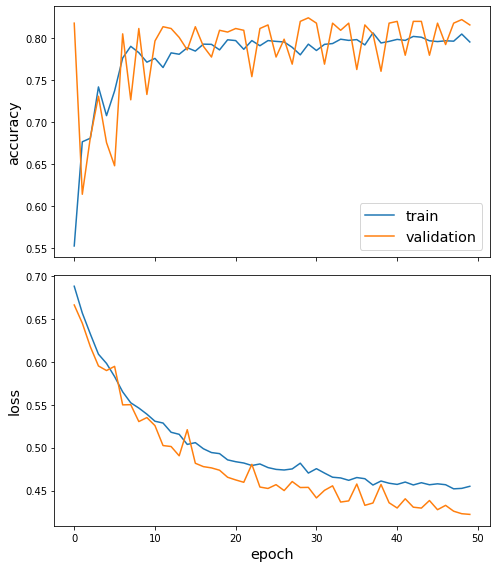

In [13]:
plot_history(history)

### Validation

In [14]:
data = None

In [15]:
BND_BOX_SIZE = (80, 80)
STEP_SIZE = 20

dataset_loader = AerialCarsDatasetLoader(
    image_loader=AerialCarsFixedSizeImageLoader(
        bnd_box_size=BND_BOX_SIZE
    )
)

process_pipeline=RawImageToImage(
    processors=[
        NormImage()
    ]
)

sliding_window = SlidingWindow(
    step_size=STEP_SIZE,
    window_size=BND_BOX_SIZE
)

#### treshold = 0.7; nms_overlap=0.4

In [16]:
processed_images = None

slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.7,
    nms_overlap=0.4
)

true_positives, false_positives, false_negatives, processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath=DRIVE_PATH+'data/raw/aerial-cars-dataset/val',
    output_folder_filepath=DRIVE_PATH+'processed_images/resnet18/aerial-cars-dataset/t7nms4',
    images_files_types=('jpg', 'JPG', 'png'),
    annotations_files_types=('txt',),
    detector=slider_detector,
    workers=0
)

print()
print('Precision:',  round(precision(true_positives, false_positives), 3))
print('Recall:',  round(recall(true_positives, false_negatives), 3))
print('F1Score:', round(f1_score(true_positives, false_positives, false_negatives), 3))

 11%|█         | 1/9 [00:03<00:31,  4.00s/it]

386
912


 33%|███▎      | 3/9 [00:10<00:21,  3.59s/it]

267


 44%|████▍     | 4/9 [00:13<00:17,  3.47s/it]

226


 56%|█████▌    | 5/9 [00:16<00:13,  3.40s/it]

327
223


 78%|███████▊  | 7/9 [00:39<00:13,  6.78s/it]

355


 89%|████████▉ | 8/9 [00:43<00:05,  5.76s/it]

372


100%|██████████| 9/9 [00:46<00:00,  5.17s/it]

746



Precision: 0.069
Recall: 0.504
F1Score: 0.122


#### treshold = 0.8; nms_overlap=0.4

In [17]:
processed_images = None

slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.8,
    nms_overlap=0.4
)

true_positives, false_positives, false_negatives, processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath=DRIVE_PATH+'data/raw/aerial-cars-dataset/val',
    output_folder_filepath=DRIVE_PATH+'processed_images/resnet18/aerial-cars-dataset/t8nms4',
    images_files_types=('jpg', 'JPG', 'png'),
    annotations_files_types=('txt',),
    detector=slider_detector,
    workers=0
)

print()
print('Precision:',  round(precision(true_positives, false_positives), 3))
print('Recall:',  round(recall(true_positives, false_negatives), 3))
print('F1Score:', round(f1_score(true_positives, false_positives, false_negatives), 3))

 11%|█         | 1/9 [00:03<00:27,  3.44s/it]

243


 22%|██▏       | 2/9 [00:06<00:23,  3.43s/it]

567


 33%|███▎      | 3/9 [00:10<00:20,  3.39s/it]

154


 44%|████▍     | 4/9 [00:13<00:16,  3.37s/it]

129


 56%|█████▌    | 5/9 [00:16<00:13,  3.36s/it]

191


 67%|██████▋   | 6/9 [00:34<00:23,  7.72s/it]

91


 78%|███████▊  | 7/9 [00:38<00:12,  6.42s/it]

156


 89%|████████▉ | 8/9 [00:41<00:05,  5.49s/it]

250


100%|██████████| 9/9 [00:45<00:00,  5.01s/it]

435



Precision: 0.092
Recall: 0.398
F1Score: 0.15


#### treshold = 0.9; nms_overlap=0.4

In [18]:
processed_images = None

slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.9,
    nms_overlap=0.4
)

true_positives, false_positives, false_negatives, processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath=DRIVE_PATH+'data/raw/aerial-cars-dataset/val',
    output_folder_filepath=DRIVE_PATH+'processed_images/resnet18/aerial-cars-dataset/t9nms4',
    images_files_types=('jpg', 'JPG', 'png'),
    annotations_files_types=('txt',),
    detector=slider_detector,
    workers=0
)

print()
print('Precision:',  round(precision(true_positives, false_positives), 3))
print('Recall:',  round(recall(true_positives, false_negatives), 3))
print('F1Score:', round(f1_score(true_positives, false_positives, false_negatives), 3))

 11%|█         | 1/9 [00:03<00:27,  3.45s/it]

102


 22%|██▏       | 2/9 [00:06<00:23,  3.41s/it]

272


 33%|███▎      | 3/9 [00:10<00:20,  3.38s/it]

72


 44%|████▍     | 4/9 [00:13<00:16,  3.36s/it]

65


 56%|█████▌    | 5/9 [00:16<00:13,  3.35s/it]

87


 67%|██████▋   | 6/9 [00:31<00:20,  6.78s/it]

26


 78%|███████▊  | 7/9 [00:35<00:11,  5.83s/it]

31


 89%|████████▉ | 8/9 [00:38<00:05,  5.07s/it]

107


100%|██████████| 9/9 [00:41<00:00,  4.64s/it]

180



Precision: 0.11
Recall: 0.221
F1Score: 0.147
